<a href="https://colab.research.google.com/github/ssawant/ml-jupyter-notebook/blob/master/credit_card_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"santoshsawant","key":"a1f1b349b891ec618054d1a8f5781bb4"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle competitions download -c ieee-fraud-detection

 63% 33.0M/52.5M [00:00<00:00, 83.1MB/s]
100% 52.5M/52.5M [00:00<00:00, 150MB/s] 
  0% 0.00/3.02M [00:00<?, ?B/s]
100% 3.02M/3.02M [00:00<00:00, 98.7MB/s]
 65% 31.0M/47.3M [00:00<00:00, 68.1MB/s]
100% 47.3M/47.3M [00:00<00:00, 158MB/s] 
  0% 0.00/2.97M [00:00<?, ?B/s]
100% 2.97M/2.97M [00:00<00:00, 98.4MB/s]
  0% 0.00/1.14M [00:00<?, ?B/s]
100% 1.14M/1.14M [00:00<00:00, 156MB/s]


In [4]:
!unzip train_identity.csv.zip
!unzip train_transaction.csv.zip

Archive:  train_identity.csv.zip
  inflating: train_identity.csv      
Archive:  train_transaction.csv.zip
  inflating: train_transaction.csv   


**Preprocessing Data**

In [0]:
import pandas as pd
df_train_id = pd.read_csv('train_identity.csv')
df_train_tran = pd.read_csv('train_transaction.csv')

Helper function to reduce dataframe memory

In [0]:
# credit to @guiferviz for the memory reduction 
def memory_usage_mb(df, *args, **kwargs):
    """Dataframe memory usage in MB. """
    return df.memory_usage(*args, **kwargs).sum() / 1024**2

def reduce_memory_usage(df, deep=True, verbose=True):
    # All types that we want to change for "lighter" ones.
    # int8 and float16 are not include because we cannot reduce
    # those data types.
    # float32 is not include because float16 has too low precision.
    numeric2reduce = ["int16", "int32", "int64", "float64"]
    start_mem = 0
    if verbose:
        start_mem = memory_usage_mb(df, deep=deep)

    for col, col_type in df.dtypes.iteritems():
        best_type = None
        if col_type in numeric2reduce:
            downcast = "integer" if "int" in str(col_type) else "float"
            df[col] = pd.to_numeric(df[col], downcast=downcast)
            best_type = df[col].dtype.name
        # Log the conversion performed.
        if verbose and best_type is not None and best_type != str(col_type):
            print(f"Column '{col}' converted from {col_type} to {best_type}")
    
    if verbose:
        end_mem = memory_usage_mb(df, deep=deep)
        diff_mem = start_mem - end_mem
        percent_mem = 100 * diff_mem / start_mem
        print(f"Memory usage decreased from"
              f" {start_mem:.2f}MB to {end_mem:.2f}MB"
              f" ({diff_mem:.2f}MB, {percent_mem:.2f}% reduction)")
        
    return df


In [0]:
df_train = pd.merge(df_train_tran, df_train_id, on='TransactionID', how='left')

In [8]:
print(f'Train dataset has {df_train.shape[0]} rows and {df_train.shape[1]} columns.')

Train dataset has 590540 rows and 434 columns.


In [0]:
del df_train_tran, df_train_id

In [10]:
# df_train.head()
memory_usage_mb(df_train)

1959.8762512207031

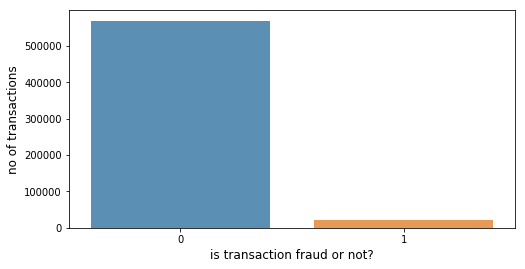

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
count = df_train['isFraud'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(count.index, count.values, alpha=0.8)
plt.ylabel('no of transactions', fontsize=12)
plt.xlabel('is transaction fraud or not?', fontsize=12)
plt.show()

Text(0.5, 1.0, 'Proportion of Missing Values in Input Features')

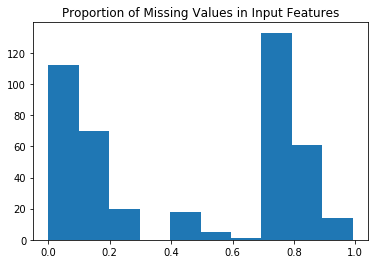

In [12]:
no_data_sample = len(df_train.index)

input_features_missing_proportions = df_train.isnull().sum() / no_data_sample

plt.hist(input_features_missing_proportions)
plt.title('Proportion of Missing Values in Input Features')

Removing columns which has more then 60% nan values

In [0]:
df_train = df_train.loc[:, df_train.isnull().mean() <=.6]

In [14]:
df_train.shape
memory_usage_mb(df_train) # 937 MB reduction

1022.7400207519531

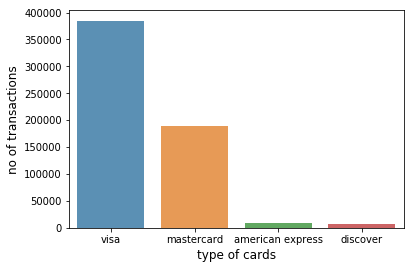

In [15]:
count = df_train['card4'].value_counts()

sns.barplot(count.index, count.values, alpha=0.8)
plt.ylabel('no of transactions', fontsize=12)
plt.xlabel('type of cards', fontsize=12)
plt.show()

In [16]:
df_train.select_dtypes(exclude=['int', 'float']).columns

Index(['ProductCD', 'card4', 'card6', 'P_emaildomain', 'M1', 'M2', 'M3', 'M4',
       'M5', 'M6', 'M7', 'M8', 'M9'],
      dtype='object')

In [17]:
numeric_col = df_train._get_numeric_data().columns
numeric_col

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'V312', 'V313', 'V314', 'V315', 'V316', 'V317', 'V318', 'V319', 'V320',
       'V321'],
      dtype='object', length=213)

In [18]:
memory_usage_mb(df_train)

1022.7400207519531

In [0]:
# replacing null missing value with mean of dataset
numeric_column = [i for i in numeric_col]
for i in numeric_column:
  df_train[i]=df_train[i].fillna(df_train[i].median())

In [20]:
data_num = df_train[numeric_column]
data_num.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,V1,V2,V3,V4,V5,V6,V7,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,13926,361.0,150.0,142.0,315.0,87.0,19.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,13.0,13.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,2755,404.0,150.0,102.0,325.0,87.0,8.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,43.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,4663,490.0,150.0,166.0,330.0,87.0,287.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,315.0,315.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,18132,567.0,150.0,117.0,476.0,87.0,8.0,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,43.0,111.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,4497,514.0,150.0,102.0,420.0,87.0,8.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,26.0,10.0,15.0,43.0,52.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
num_cat = df_train.select_dtypes(exclude=['int', 'float']).columns
num_cat = [i for i in num_cat]
num_cat

['ProductCD',
 'card4',
 'card6',
 'P_emaildomain',
 'M1',
 'M2',
 'M3',
 'M4',
 'M5',
 'M6',
 'M7',
 'M8',
 'M9']

In [22]:
from sklearn.impute import SimpleImputer
imp = SimpleImputer(strategy='most_frequent')
imp.fit(df_train[num_cat])

SimpleImputer(add_indicator=False, copy=True, fill_value=None,
              missing_values=nan, strategy='most_frequent', verbose=0)

In [0]:
df_train[num_cat] = imp.transform(df_train[num_cat])
data_cat = df_train[num_cat]

In [24]:
data_cat.head()

,ProductCD,card4,card6,P_emaildomain,M1,M2,M3,M4,M5,M6,M7,M8,M9
0,W,discover,credit,gmail.com,T,T,T,M2,F,T,F,F,T
1,W,mastercard,credit,gmail.com,T,T,T,M0,T,T,F,F,T
2,W,visa,debit,outlook.com,T,T,T,M0,F,F,F,F,F
3,W,mastercard,debit,yahoo.com,T,T,T,M0,T,F,F,F,T
4,H,mastercard,credit,gmail.com,T,T,T,M0,F,F,F,F,T


In [25]:
# finding no of category in categorical columns
data_cat = data_cat.astype('category')
cat_level = data_cat.apply(lambda col: len(col.cat.categories))
cat_level

ProductCD         5
card4             4
card6             4
P_emaildomain    59
M1                2
M2                2
M3                2
M4                3
M5                2
M6                2
M7                2
M8                2
M9                2
dtype: int64

In [26]:
df_train.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,P_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D10,D11,D15,M1,M2,M3,...,V282,V283,V284,V285,V286,V287,V288,V289,V290,V291,V292,V293,V294,V295,V296,V297,V298,V299,V300,V301,V302,V303,V304,V305,V306,V307,V308,V309,V310,V311,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,W,13926,361.0,150.0,discover,142.0,credit,315.0,87.0,19.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,1.0,14.0,97.0,13.0,26.0,10.0,13.0,13.0,0.0,T,T,T,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,117.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,credit,325.0,87.0,8.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,43.0,0.0,T,T,T,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,debit,330.0,87.0,287.0,outlook.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,0.0,10.0,0.0,315.0,315.0,T,T,T,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,debit,476.0,87.0,8.0,yahoo.com,2.0,5.0,0.0,0.0,0.0,4.0,0.0,0.0,1.0,0.0,1.0,0.0,25.0,1.0,112.0,112.0,0.0,94.0,0.0,84.0,43.0,111.0,T,T,T,...,0.0,0.0,0.0,10.0,0.0,4.0,0.0,0.0,1.0,1.0,1.0,1.0,38.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,50.0,1758.0,925.0,0.0,354.0,0.0,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,credit,420.0,87.0,8.0,gmail.com,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,97.0,8.0,26.0,10.0,15.0,43.0,52.0,T,T,T,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [0]:
data_cat = pd.get_dummies(data_cat[num_cat])

In [0]:
df = pd.concat([data_num, data_cat], axis=1)

In [29]:
del df_train
del data_num
del data_cat
# del cat_level
!free -h

              total        used        free      shared  buff/cache   available
Mem:            12G        8.8G        605M        840K        3.3G         11G
Swap:            0B          0B          0B


Traning and test data

In [30]:
df = reduce_memory_usage(df, deep=True, verbose=True)

Column 'TransactionID' converted from int64 to int32
Column 'isFraud' converted from int64 to int8
Column 'TransactionDT' converted from int64 to int32
Column 'TransactionAmt' converted from float64 to float32
Column 'card1' converted from int64 to int16
Column 'card2' converted from float64 to float32
Column 'card3' converted from float64 to float32
Column 'card5' converted from float64 to float32
Column 'addr1' converted from float64 to float32
Column 'addr2' converted from float64 to float32
Column 'dist1' converted from float64 to float32
Column 'C1' converted from float64 to float32
Column 'C2' converted from float64 to float32
Column 'C3' converted from float64 to float32
Column 'C4' converted from float64 to float32
Column 'C5' converted from float64 to float32
Column 'C6' converted from float64 to float32
Column 'C7' converted from float64 to float32
Column 'C8' converted from float64 to float32
Column 'C9' converted from float64 to float32
Column 'C10' converted from float64 t

In [0]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(df.iloc[:,3:], df['isFraud'], test_size=0.20, random_state=42)

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import BernoulliNB 

# Train LogisticRegression Model
LGR_Classifier = LogisticRegression(max_iter=500)
LGR_Classifier.fit(X_train, y_train)

# Train Decision Tree Model
RDF_Classifier = RandomForestClassifier(random_state=0)
RDF_Classifier.fit(X_train, y_train)

# Train Bernoulli Navi Baye Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [0]:
from sklearn.model_selection import cross_val_score
from sklearn import metrics
import numpy as np

# Evaluate Models
modelist = [('RandomForest Classifier', RDF_Classifier), ('LogisticRegression', LGR_Classifier), ('Navi Baiya Classifier', BNB_Classifier)]
# modelist = [('RandomForest Classifier', RDF_Classifier), ('Navi Baiya Classifier', BNB_Classifier)]
# modelist = [('RandomForest Classifier', RDF_Classifier)]
models = [j for j in modelist]

print('================ Model Evaluation Results ===================' "\n")

for i, v in models:
  scores = cross_val_score(v, X_train, y_train, cv=10)
  accuracy = metrics.accuracy_score(y_train, v.predict(X_train))
  confusion_matrix = metrics.confusion_matrix(y_train, v.predict(X_train))
  classification = metrics.classification_report(y_train, v.predict(X_train))
  print(f'============ {i} ============')
  print()
  print(f'Cross Validation Mean Score: {np.round(scores.mean(), 3) * 100}')
  print()
  print(f'Model Accuracy: {np.round(accuracy, 3) * 100}')
  print()
  print(f'Confusion Matrix: \n{confusion_matrix}')
  print()
  print(f'Classification Report: \n{classification}')

================ Model Evaluation Results ===================




===================== Model Test Result ======================

======== RandomForest Classifier =========
Model Accuracy: 97.8

Confusion Matrix: [[113637    229]
 [  2423   1819]]



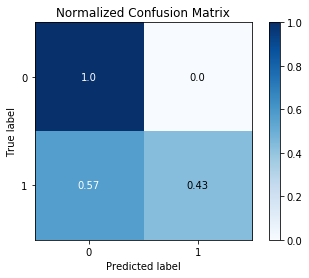


Classification Report: 
              precision    recall  f1-score   support

           0       0.98      1.00      0.99    113866
           1       0.89      0.43      0.58      4242

    accuracy                           0.98    118108
   macro avg       0.93      0.71      0.78    118108
weighted avg       0.98      0.98      0.97    118108


============================= ROC Curve ===============================



IndexError: ignored

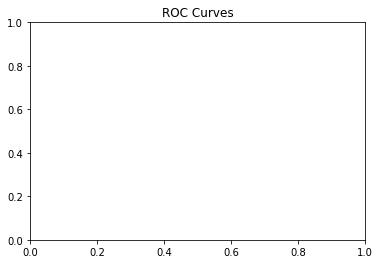

In [44]:
# Test Model
!pip install scikit-plot
import scikitplot as skplt

classdict = {'normal':0, 'fraudulent':1}
print()
print('===================== Model Test Result ======================' "\n")

for i, v in models:
  y_pred = v.predict(X_val)
  accuracy = metrics.accuracy_score(y_val, y_pred)
  confusion_matrix = metrics.confusion_matrix(y_val, y_pred)
  classification = metrics.classification_report(y_val, y_pred)
  print(f'======== {i} =========')
  print (f'Model Accuracy: {np.round(accuracy, 3) * 100}')
  print()
  print(f'Confusion Matrix: {confusion_matrix}')
  print()
  # plt.plot_confusion_matrix(confusion_matrix, classes = list(classdict.keys()), title='Confusion Matrix Plot', cmap=plt.cm.summer)
  skplt.metrics.plot_confusion_matrix(y_val, y_pred, normalize=True)
  plt.show()
  print() 
  print(f'Classification Report: \n{classification}') 
  print() 

print('============================= ROC Curve ===============================' "\n")
# pf.plot_roc_auc(arg1=models, arg2=X_test, arg3=y_test)     
# skplt.metrics.plot_roc(y_val, y_pred)
